<a href="https://colab.research.google.com/github/FatoniRahmat/Portofolio-Data-Analyst-in-Python/blob/main/Travel_Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CLASSIFICATION PREDICTION TRAVEL INSURANCE**

**Problem Statement**
* In the travel insurance industry, companies strive to provide policies that are not only competitive but also adequate to cover the risks associated with a customer's travel. With the number of tourists increasing every year, it is necessary to understand the various factors that influence insurance claims. Managing and predicting these claims is important to maintain a balance between providing protection to customers and maintaining the insurance company's financial sustainability.
* One of the main challenges is predicting the likelihood of customers making travel insurance claims. Inaccurate predictions can cause financial losses for insurance companies and can result in premium prices that are not optimal for customers.

**My Task**
* Conduct exploratory analysis of data to understand the distribution and relationships between variables. Then apply a classification algorithm to build a model that can predict claim probability.
* Analyze this data to determine whether someone will claim insurance or not. After that, build a classification model to help companies find what criteria might be the determining factor for someone to make an insurance claim.

#Setup Environment & Run Packages

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

#Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

#Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.svm import SVC

#Imbalance Dataset
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

#Save Model
import joblib

#Ignore Warning
import sys
import warnings
warnings.filterwarnings("ignore")
if not sys.warnoptions:
    warnings.simplefilter("ignore")

#Set max columns
pd.set_option('display.max_columns', None)

#Load Data

In [4]:
#Read data from google sheet
sheet_url = 'https://docs.google.com/spreadsheets/d/12Ki7cOZl5DpiGnvf-UO9-umEOLkbEJH-IFEMFhjYURo/edit#gid=685007823'
sheet_url_trf = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
df = pd.read_csv(sheet_url_trf)
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


In [5]:
#Knowing the number of rows and columns
print("dataset has {} rows and {} columns".format(*df.shape))

dataset has 44328 rows and 11 columns


#Basic Steps
1. Check variable names

2. Check data type

3. Handle missing values

4. Check duplicate records

5. Checking summary statistics

##1. Check variable names
Column names provide a clear identification of the data contained within each column. By reviewing the column names, i can quickly understand the type of information stored in each column. This helps me make sense of the data and interpret it correctly.


In [6]:
#Check columns
df.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Gender', 'Duration', 'Destination', 'Net Sales',
       'Commision (in value)', 'Age', 'Claim'],
      dtype='object')

The column name data contained in each column is very clear.

##2. Check data type
Checking the data types is an important step in data cleaning because it helps ensure the consistency, accuracy, and reliability of the data.

In [7]:
#Check data type
df.dtypes

Agency                   object
Agency Type              object
Distribution Channel     object
Product Name             object
Gender                   object
Duration                  int64
Destination              object
Net Sales               float64
Commision (in value)    float64
Age                       int64
Claim                    object
dtype: object

There is nothing wrong with the data type

##3. Handle Missing Values
Checking for missing values is an important step in data cleaning because missing values can have a significant impact on the quality and reliability of the data analysis. Missing values can lead to incomplete or inaccurate data, which can skew the analysis and produce misleading results. By identifying and handling missing values appropriately, me ensure the integrity and reliability of the data.

In [8]:
#Check the amount of missing values
def nulls(df):
    null_values = pd.DataFrame(df.isnull().sum())
    null_values[1] = null_values[0] / len(df)
    null_values.columns = ['count','%pct']
    filtered_null = null_values[null_values['%pct'] > 0].sort_values(by='%pct', ascending=False)
    return filtered_null
nulls(df)

,count,%pct
Gender,31647,0.713928


There is a missing value in the gender column, because in this case we cannot identify a person's gender from the data provided, there are no variables that can identify a person's gender. And also in this case the gender column is also not relevant for use in the machine learning model this time, because the gender column cannot identify whether someone will make an insurance claim or not, so we can delete the gender column.

In [9]:
#Remove missing values
df.drop(['Gender'],axis=1, inplace=True)
df.isna().sum()

Agency                  0
Agency Type             0
Distribution Channel    0
Product Name            0
Duration                0
Destination             0
Net Sales               0
Commision (in value)    0
Age                     0
Claim                   0
dtype: int64

##4. Check Duplicate Rows
Duplicate rows can compromise the integrity of the dataset. If we have multiple identical rows, it can lead to inaccurate statistical analysis, misleading results, and duplicate entries in downstream processes. By identifying and removing duplicate rows, we ensure that the data accurately represents the underlying information.

In [10]:
#Check for duplicate data
df.duplicated().sum()

5004

Because there is no user ID column, we cannot identify whether the duplicate data in the dataset is truly duplicate data or not, so we will just assume that the dataset does not have duplicate data.

##5. Checking Summary Statistics

In [11]:
#Statistics of numerical columns
df.describe()

,Duration,Net Sales,Commision (in value),Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


In [12]:
#Statistics of non-numerical columns
df.describe(include = np.object_)

,Agency,Agency Type,Distribution Channel,Product Name,Destination,Claim
count,44328,44328,44328,44328,44328,44328
unique,16,2,2,26,138,2
top,EPX,Travel Agency,Online,Cancellation Plan,SINGAPORE,No
freq,24656,32113,43572,12979,9267,43651


After we look at the data distribution, there are anomalies in duration and age.

* In the duration column we found that there was data that had a value of -1 so it was impossible for the duration of a trip to be minus.

* In the age column, we find that there is data that has a max value of 118, this value is not relevant to the current human age, so it can be said that the data is invalid and needs to be deleted.

In [13]:
#Removes rows with 'duration' -1
df.drop(df[df['Duration'] == -1].index, inplace=True)

#Removed the row with 'age' 118
df.drop(df[df['Age'] == 118].index, inplace=True)

In [14]:
#Check again
df.describe()

,Duration,Net Sales,Commision (in value),Age
count,43652.000000,43652.000000,43652.000000,43652.000000
mean,49.736369,40.406396,9.558039,38.716531
std,109.882072,48.648192,19.608595,10.094275
min,0.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.000000,0.000000,36.000000
75%,53.000000,48.000000,10.500000,42.000000
max,4881.000000,682.000000,262.760000,88.000000


An anomaly is still found where the minimum duration and age are 0. This is impossible because the trip duration and age cannot be 0, let's delete it.

In [15]:
#Remove minimum duration and age value 0
df.drop(df[df['Duration'] == 0].index, inplace=True)
df.drop(df[df['Age'] == 0].index, inplace=True)

In [16]:
#Statistics of numerical columns
df.describe()

,Duration,Net Sales,Commision (in value),Age
count,43621.000000,43621.000000,43621.000000,43621.000000
mean,49.767406,40.427208,9.560950,38.716696
std,109.913217,48.658014,19.614819,10.089747
min,1.000000,-357.500000,0.000000,1.000000
25%,10.000000,18.000000,0.000000,35.000000
50%,22.000000,26.000000,0.000000,36.000000
75%,53.000000,48.000000,10.500000,42.000000
max,4881.000000,682.000000,262.760000,88.000000


The anomaly has been handled.

#Check Data Imbalance

In [17]:
#Cek distribusi value claim
df['Claim'].value_counts()/df.shape[0]

No     0.98464
Yes    0.01536
Name: Claim, dtype: float64

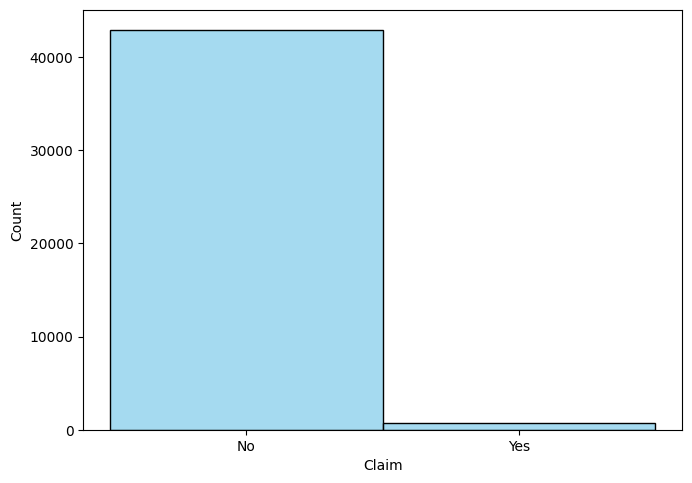

In [18]:
#Show distribusi value claim
plt.figure(figsize=(17,12))
plt.subplot(221)
sns.histplot(data=df, x='Claim', color='skyblue')
plt.show()

It can be seen that there is quite a large data imbalance between the values No and Yes.

We continue by doing Imbalance over_Sampling on the Yes value.

In [19]:
encoder_dict = {}

#Encode categorical values to numeric
for column in df.select_dtypes(include=['object']).columns:
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])
    encoder_dict[column] = encoder

In [20]:
x = df.drop('Claim', axis=1)
y = df['Claim']

In [21]:
print(x.shape)
print(y.shape)

(43621, 9)
(43621,)


In [22]:
#Synthetic Minority Over-sampling Technique (SMOTE)
sm = SMOTE(random_state=42)
x_resampled, y_resampled = sm.fit_resample(x, y)

In [23]:
#Added synthetic data
print(x_resampled.shape)
print(y_resampled.shape)

(85902, 9)
(85902,)


In [24]:
#Resampled
df_resampled = pd.DataFrame(x_resampled, columns=x.columns)
df_resampled['Claim'] = y_resampled

In [25]:
##Show dataset encoder
df_resampled.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,2,0,1,4,365,109,216.0,54.0,57,0
1,7,1,1,10,4,73,10.0,0.0,33,0
2,8,0,1,8,19,52,22.0,7.7,26,0
3,7,1,1,1,20,128,112.0,0.0,59,0
4,2,0,1,9,8,109,16.0,4.0,28,0


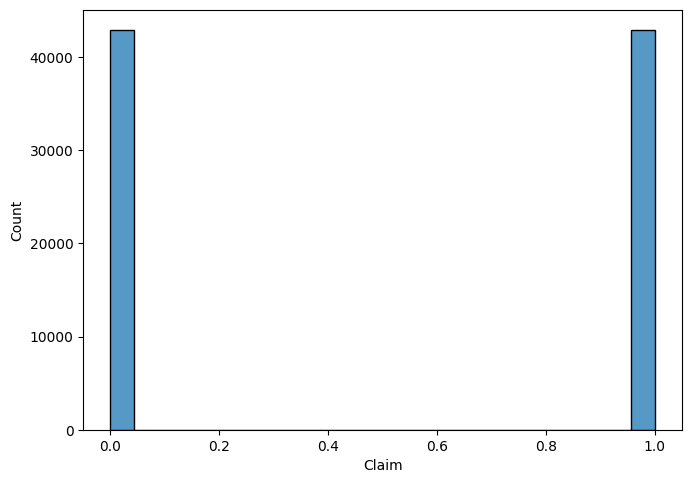

In [26]:
#Show value claim distribution after encoder
plt.figure(figsize=(17,12))
plt.subplot(221)
sns.histplot(data=y_resampled)
plt.show()

Returns the Variable object to its original form for the target analysis needs.

In [27]:
#Returns encoder
for column, encoder in encoder_dict.items():
    if column in df_resampled.columns:
        df_resampled[column] = encoder.inverse_transform(df_resampled[column])

#Export the File
Export cleaned data.

In [28]:
#Show dataset
df_resampled.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.0,28,No


In [29]:
#Knowing the number of rows and columns
print("dataset has {} rows and {} columns".format(*df_resampled.shape))

dataset has 85902 rows and 10 columns


In [30]:
#Export data
df_resampled.to_csv('Insurance_Dataset_Cleaned.csv')

#Exploratory Data Analysis (EDA)

* The fundamental purpose of exploratory data analysis is to aid in the examination of data prior to making any assumptions.
* It can aid in the detection of obvious errors, the understanding of data patterns, the detection of outliers or unexpected events, and the discovery of noteworthy connections between variables.

##1. Insurance Claims Based on Duration and Age

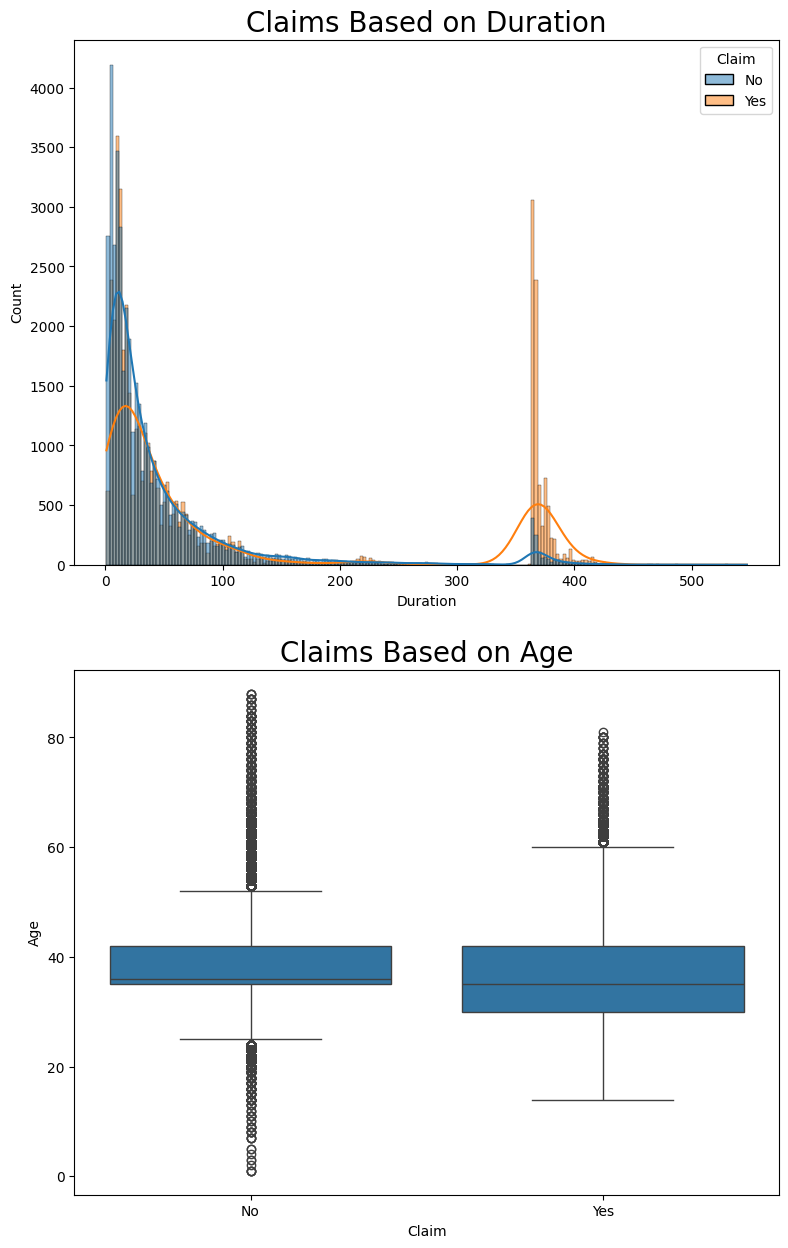

In [31]:
#Claims graph based on duration and age
df_resampled1 = df_resampled.loc[df_resampled['Duration'] <= 700]

plt.figure(figsize=(20,15))

plt.subplot(221)
sns.histplot(data=df_resampled1, x='Duration', hue='Claim', kde=True,) #log_scale=True
plt.title('Claims Based on Duration', fontsize=20)

plt.subplot(223)
sns.boxplot(data=df_resampled1,y='Age', x='Claim')
plt.title('Claims Based on Age', fontsize=20)
plt.show()

**Insight:**

* As seen in the Duration histogram, there is a pattern where the distribution of yes values is dominated by durations above 300 days.

###Histogram of claims by duration

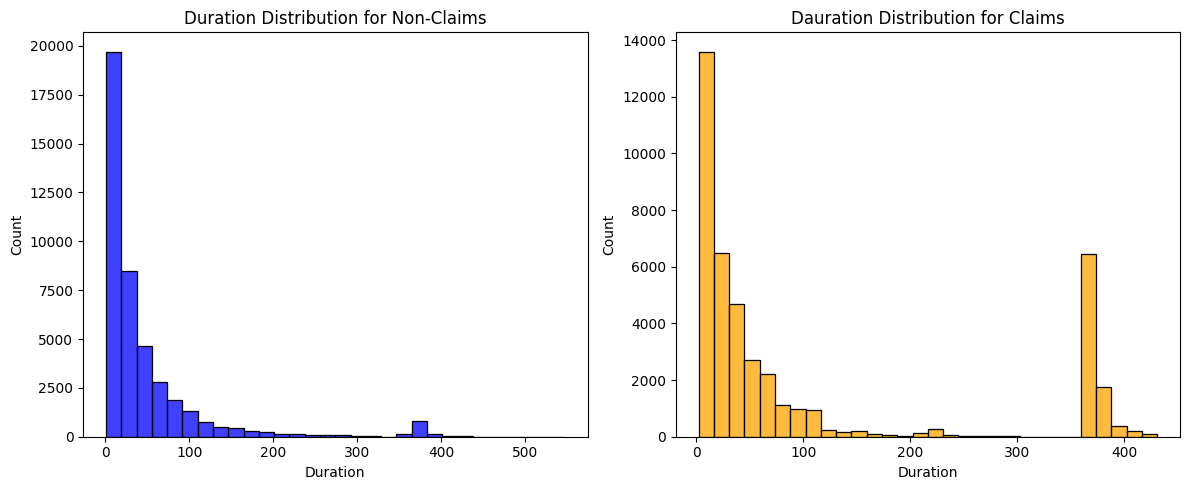

In [32]:
#Duration distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_resampled1[df_resampled1['Claim'] == 'No']['Duration'], bins=30, kde=False, color='blue')
plt.title('Duration Distribution for Non-Claims')

plt.subplot(1, 2, 2)
sns.histplot(df_resampled1[df_resampled1['Claim'] == 'Yes']['Duration'], bins=30, kde=False, color='orange')
plt.title('Dauration Distribution for Claims')

plt.tight_layout()
plt.show()

**Insight:**

* It turns out that the most risky value yes occurs above the duration value of 200 days.

###Histogram of claims by age

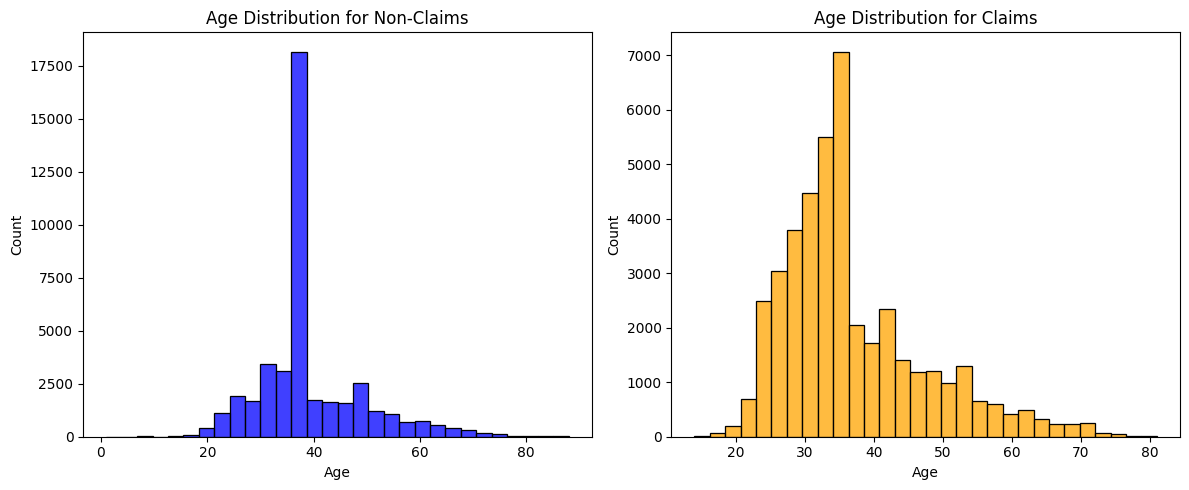

In [33]:
#Age distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_resampled1[df_resampled1['Claim'] == 'No']['Age'], bins=30, kde=False, color='blue')
plt.title('Age Distribution for Non-Claims')

plt.subplot(1, 2, 2)
sns.histplot(df_resampled1[df_resampled1['Claim'] == 'Yes']['Age'], bins=30, kde=False, color='orange')
plt.title('Age Distribution for Claims')

plt.tight_layout()
plt.show()

**Insight:**

* It appears that age does not have a definite reference for someone making a claim or not, perhaps the histogram visualization does not provide sufficient information.

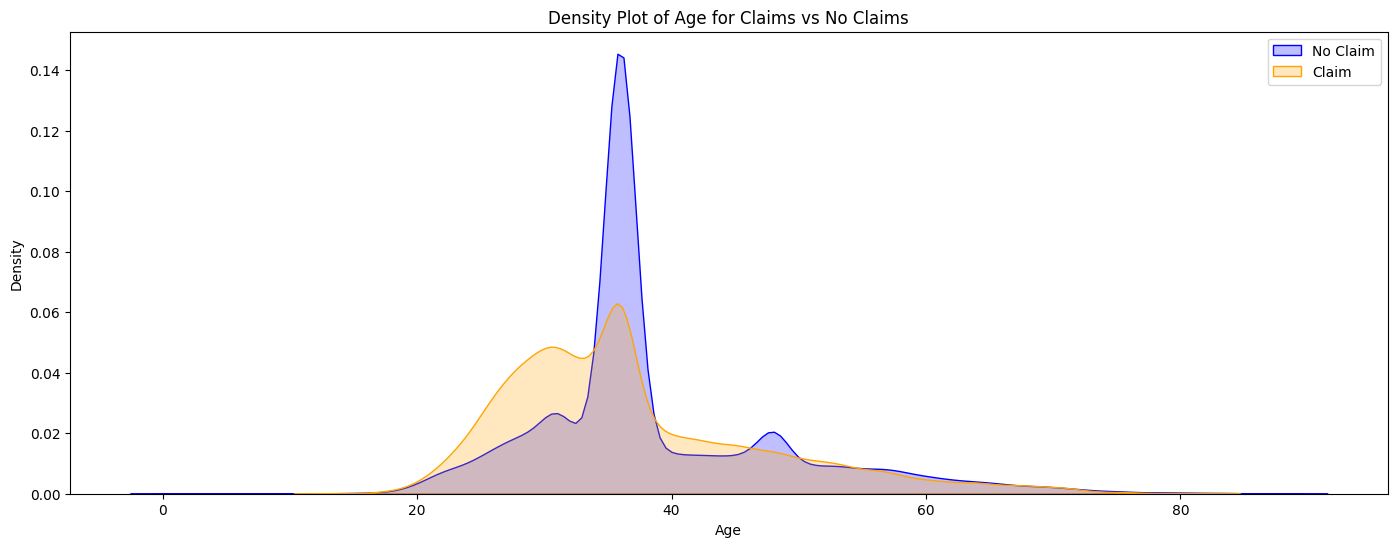

In [34]:
#Density plot of age
plt.figure(figsize=(17, 6))

sns.kdeplot(data=df_resampled[df_resampled['Claim'] == 'No'], x='Age', shade=True, label='No Claim', color='blue')

sns.kdeplot(data=df_resampled[df_resampled['Claim'] == 'Yes'], x='Age', shade=True, label='Claim', color='orange')

plt.title('Density Plot of Age for Claims vs No Claims')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()

plt.show()

**Insight:**

* It can be seen that the distribution of whether someone will claim or not has the same distribution.

##2. Distribution of Claims Based on Duration and Age.

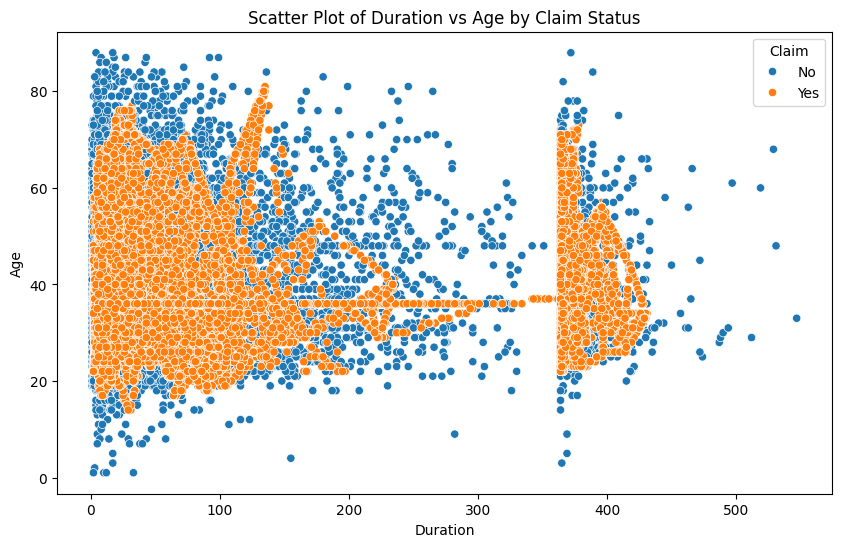

In [35]:
#Scatter plot of duration vs age
df_resampled1 = df_resampled.loc[df_resampled['Duration'] <= 700]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_resampled1, x='Duration', y='Age', hue='Claim')
plt.title('Scatter Plot of Duration vs Age by Claim Status')
plt.xlabel('Duration')
plt.ylabel('Age')
plt.legend(title='Claim')
plt.show()

In [36]:
#Age group
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
labels = ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90']
df_resampled1['Age Group'] = pd.cut(df_resampled1['Age'], bins=bins, labels=labels, right=False)
1
grouped = df_resampled1.groupby(['Age Group', 'Claim']).size().unstack().fillna(0)
normalized_grouped = grouped.div(grouped.sum(axis=1), axis=0)
normalized_grouped['count'] = df_resampled1.groupby('Age Group')['Claim'].count()

display(normalized_grouped)

Claim,No,Yes,count
Age Group,,,
1-10,1.000000,0.000000,24
11-20,0.515254,0.484746,295
21-30,0.334620,0.665380,15286
31-40,0.558083,0.441917,45366
41-50,0.482047,0.517953,13424
51-60,0.493450,0.506550,7405
61-70,0.527708,0.472292,3176
71-80,0.540244,0.459756,820
81-90,0.913043,0.086957,92


In [37]:
#Duration group
bins = [0, 25, 50, 75, 100, 125, 150, 200, 400, 550]
labels = ['<25', '25-50', '51-75', '76-100', '101-125', '126-150', '151-200', '201-400', '400>']
df_resampled1['Duration Group'] = pd.cut(df_resampled1['Duration'], bins=bins, labels=labels, right=False)
1
grouped = df_resampled1.groupby(['Duration Group', 'Claim']).size().unstack().fillna(0)
normalized_grouped = grouped.div(grouped.sum(axis=1), axis=0)
normalized_grouped['count'] = df_resampled1.groupby('Duration Group')['Claim'].count()

display(normalized_grouped)

Claim,No,Yes,count
Duration Group,,,
<25,0.560727,0.439273,40501
25-50,0.528099,0.471901,16762
51-75,0.504801,0.495199,8332
76-100,0.574074,0.425926,4158
101-125,0.499612,0.500388,2580
126-150,0.679548,0.320452,1061
151-200,0.762402,0.237598,1149
201-400,0.162932,0.837068,10888
400>,0.266958,0.733042,457


**Insight:**

From the Scatter Plot above we have 2 findings:

* It turns out that there is a lower and upper limit as a safe age, namely <10 and above 80> the distribution of yes data is very small and cannot even be found in data under 10 years>.

* In duration, there are 2 large groups of distribution of yes values below 200 days and above 350 days.

##3. Insurance Claims Based on Agency Type

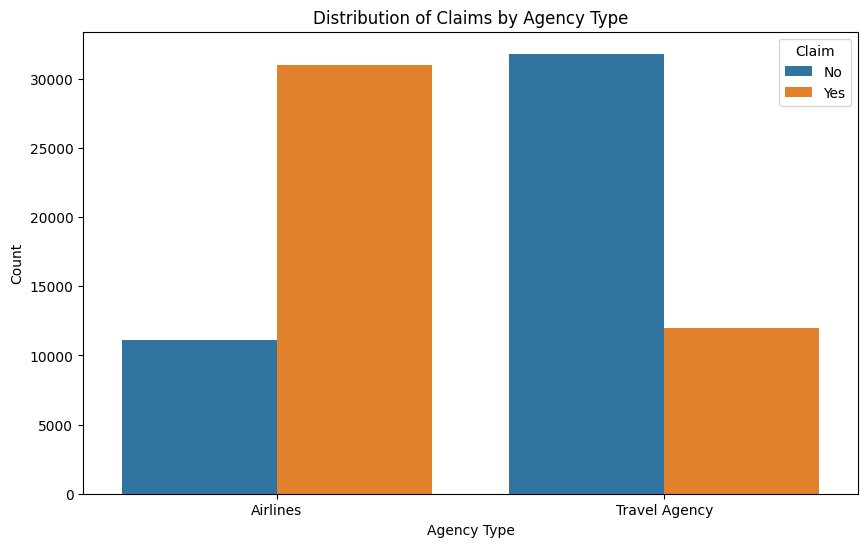

In [38]:
#Distribution graph of claims
plt.figure(figsize=(10, 6))
sns.countplot(x='Agency Type', hue='Claim', data=df_resampled)
plt.title('Distribution of Claims by Agency Type')
plt.xlabel('Agency Type')
plt.ylabel('Count')
plt.legend(title='Claim', labels=['No', 'Yes'])
plt.show()

In [39]:
#Calculate the number of claims
grouped = df_resampled1.groupby(['Agency Type', 'Claim']).size().unstack().fillna(0)
normalized_grouped = grouped.div(grouped.sum(axis=1), axis=0)
normalized_grouped['count'] = df_resampled1.groupby('Agency Type')['Claim'].count()
display(normalized_grouped.sort_values(by='Yes', ascending=False))

Claim,No,Yes,count
Agency Type,,,
Airlines,0.264247,0.735753,42097
Travel Agency,0.726473,0.273527,43791


**Insight:**

* Here we have another assumption that most of the insurance that is claimed is from Airlanes and this is a benchmark that can be taken into account.

##4. Insurance Claims Based on Agency Name

Even though the agency has no influence on the analysis results, we can check the correctness of the analysis produced by the agency type by looking at the agency.

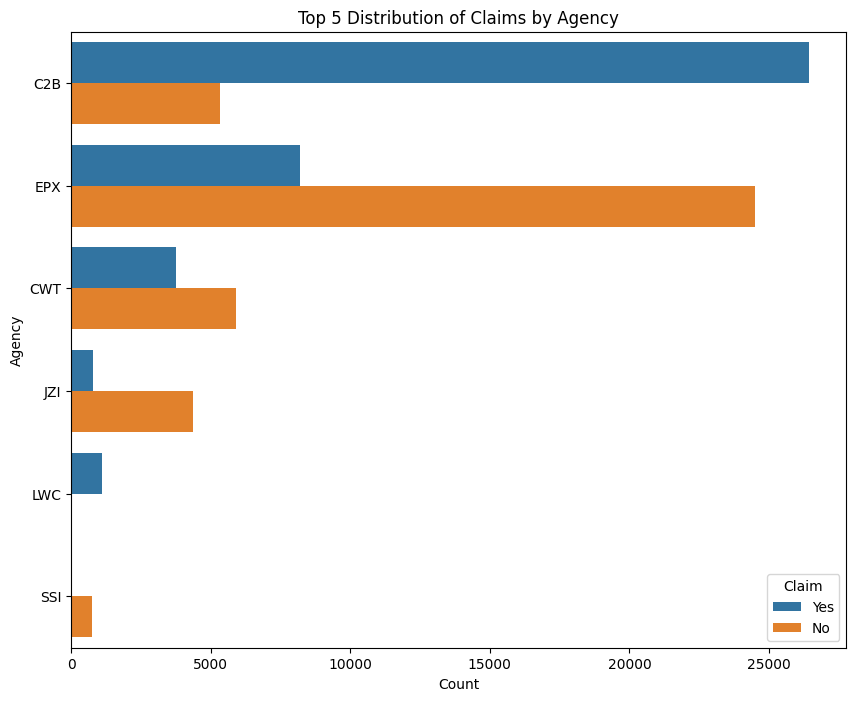

In [40]:
#Distribution of agency name
destination_counts = df_resampled.groupby('Agency')['Claim'].value_counts().reset_index(name='Count')

top_destinations = destination_counts.sort_values(by='Count', ascending=False).head(10)

plt.figure(figsize=(10, 8))
sns.barplot(x='Count', y='Agency', hue='Claim', data=top_destinations)
plt.title('Top 5 Distribution of Claims by Agency')
plt.xlabel('Count')
plt.ylabel('Agency')
plt.legend(title='Claim')
plt.show()

In [41]:
#Calculate the number of claims
grouped = df_resampled1.groupby(['Agency', 'Claim']).size().unstack().fillna(0)
grouped1 = df_resampled1.groupby(['Agency', 'Agency Type']).size().unstack().fillna(0)
normalized_grouped = grouped.div(grouped.sum(axis=1), axis=0)
normalized_grouped['count'] = df_resampled1.groupby('Agency')['Claim'].count()
normalized_grouped['count'] = df_resampled1.groupby('Agency')['Agency Type'].count()
display(normalized_grouped.sort_values(by='Yes', ascending=False).head(10), grouped1.head(10))

Claim,No,Yes,count
Agency,,,
CSR,0.100149,0.899851,669
CBH,0.115059,0.884941,591
CCR,0.132514,0.867486,732
C2B,0.168035,0.831965,31791
LWC,0.278033,0.721967,1525
KML,0.289916,0.710084,952
CWT,0.612492,0.387508,9654
EPX,0.749526,0.250474,32682
SSI,0.833525,0.166475,871


Agency Type,Airlines,Travel Agency
Agency,,
ADM,0.0,54.0
ART,193.0,0.0
C2B,31791.0,0.0
CBH,516.0,75.0
CCR,572.0,160.0
CSR,548.0,121.0
CWT,673.0,8981.0
EPX,1347.0,31335.0
JZI,4844.0,298.0


##5. Distribution of Claims on Insurance Products

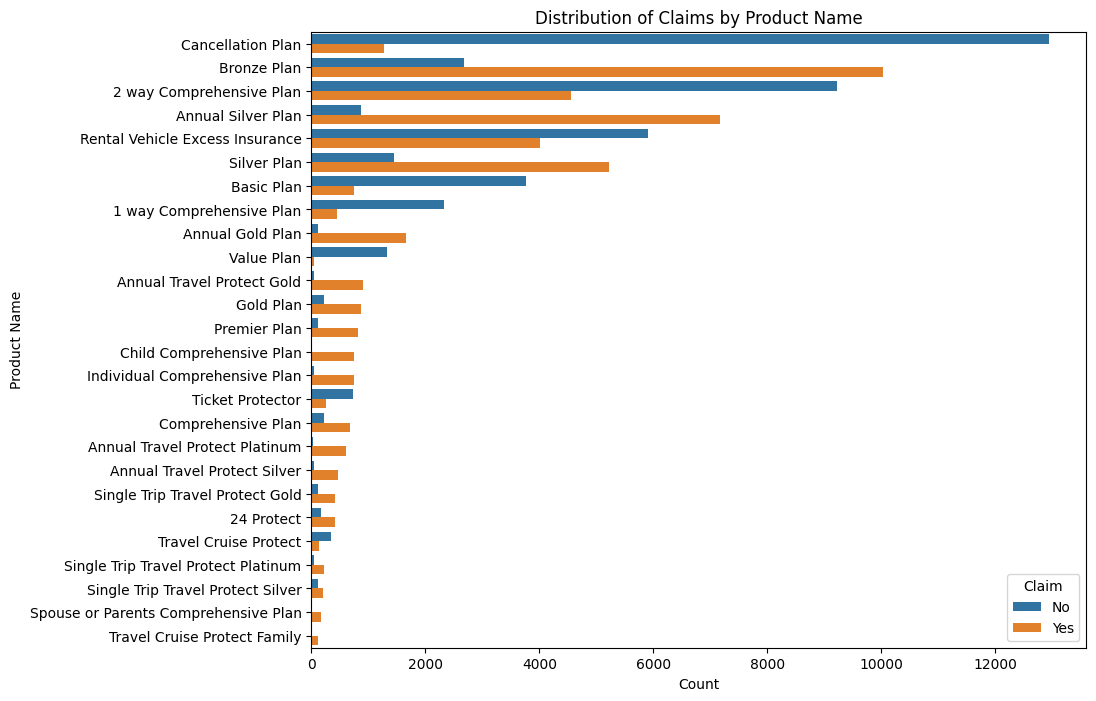

In [42]:
#Distribution of product name
destination_counts = df_resampled.groupby('Product Name')['Claim'].value_counts().reset_index(name='Count')

top_destinations = destination_counts.sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Count', y='Product Name', hue='Claim', data=top_destinations)
plt.title('Distribution of Claims by Product Name')
plt.xlabel('Count')
plt.ylabel('Product Name')
plt.legend(title='Claim')
plt.show()

In [43]:
#Calculate the number of claims
grouped = df_resampled1.groupby(['Product Name', 'Claim']).size().unstack().fillna(0)
grouped1 = df_resampled1.groupby(['Product Name', 'Agency Type']).size().unstack().fillna(0)
normalized_grouped = grouped.div(grouped.sum(axis=1), axis=0)
normalized_grouped['count'] = df_resampled1.groupby('Product Name')['Claim'].count()
display(normalized_grouped.sort_values(by='Yes', ascending=False),normalized_grouped.sort_values(by='No', ascending=False),grouped1)

Claim,No,Yes,count
Product Name,,,
Travel Cruise Protect Family,0.007874,0.992126,127
Child Comprehensive Plan,0.010444,0.989556,766
Annual Travel Protect Platinum,0.049307,0.950693,649
Annual Travel Protect Gold,0.057673,0.942327,971
Individual Comprehensive Plan,0.060759,0.939241,790
Spouse or Parents Comprehensive Plan,0.068966,0.931034,174
Annual Gold Plan,0.070234,0.929766,1794
Annual Travel Protect Silver,0.106178,0.893822,518
Annual Silver Plan,0.107654,0.892346,8035


Claim,No,Yes,count
Product Name,,,
Value Plan,0.971470,0.028530,1367
Cancellation Plan,0.910408,0.089592,14220
1 way Comprehensive Plan,0.839163,0.160837,2773
Basic Plan,0.835550,0.164450,4512
Ticket Protector,0.743091,0.256909,977
Travel Cruise Protect,0.727083,0.272917,480
2 way Comprehensive Plan,0.669692,0.330308,13772
Rental Vehicle Excess Insurance,0.595528,0.404472,9929
Single Trip Travel Protect Silver,0.346626,0.653374,326


Agency Type,Airlines,Travel Agency
Product Name,,
1 way Comprehensive Plan,17,2756
2 way Comprehensive Plan,232,13540
24 Protect,424,167
Annual Gold Plan,1607,187
Annual Silver Plan,7847,188
Annual Travel Protect Gold,232,739
Annual Travel Protect Platinum,223,426
Annual Travel Protect Silver,221,297
Basic Plan,4321,191


**Insight:**

* From the bar plot and product name table, we get the assumption that the product has an influence, there are many products where claims often occur, for example in the Annual silver plan.

##6. Insurance Claims Based on Destination

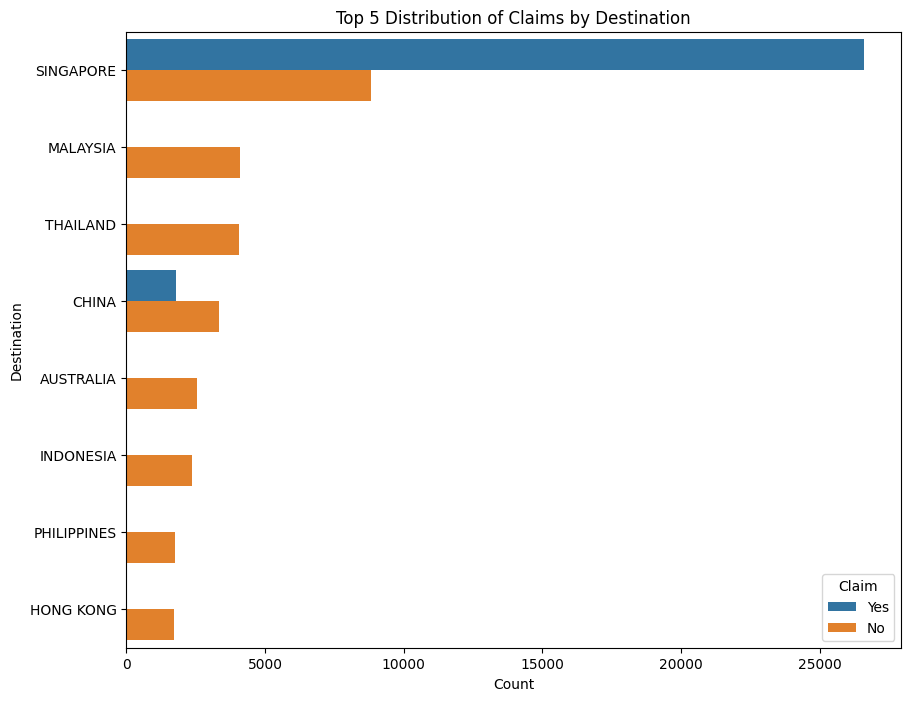

In [44]:
#Distribution of destination
destination_counts = df_resampled.groupby('Destination')['Claim'].value_counts().reset_index(name='Count')

#Top 10
top_destinations = destination_counts.sort_values(by='Count', ascending=False).head(10)

plt.figure(figsize=(10, 8))
sns.barplot(x='Count', y='Destination', hue='Claim', data=top_destinations)
plt.title('Top 5 Distribution of Claims by Destination')
plt.xlabel('Count')
plt.ylabel('Destination')
plt.legend(title='Claim')
plt.show()

In [45]:
#calculate destinations that are widely claimed and those that are not
grouped = df_resampled1.groupby(['Destination', 'Claim']).size().unstack().fillna(0)

#grouped1 = df_resampled1.groupby(['Destination', 'Agency Type', 'Product Name']).size().unstack().fillna(0)
#grouped1 = df_resampled1['Destination'] == 'ANGOLA'
normalized_grouped = grouped.div(grouped.sum(axis=1), axis=0)
normalized_grouped['count'] = df_resampled1.groupby('Destination')['Claim'].count()
display(normalized_grouped.sort_values(by='Yes', ascending=False).head(10),normalized_grouped.sort_values(by='No', ascending=False).head(10),df_resampled1[df_resampled1['Destination'] == 'TAJIKISTAN'])

Claim,No,Yes,count
Destination,,,
TAJIKISTAN,0.004292,0.995708,233
JAMAICA,0.007353,0.992647,136
TURKMENISTAN,0.007634,0.992366,131
"IRAN, ISLAMIC REPUBLIC OF",0.009346,0.990654,107
CAYMAN ISLANDS,0.010309,0.989691,97
TRINIDAD AND TOBAGO,0.013986,0.986014,143
GUYANA,0.017544,0.982456,57
NIGERIA,0.017857,0.982143,56
GUINEA-BISSAU,0.018182,0.981818,55


Claim,No,Yes,count
Destination,,,
ANGOLA,1.000000,0.000000,1
ARGENTINA,1.000000,0.000000,13
ZAMBIA,1.000000,0.000000,2
ZIMBABWE,1.000000,0.000000,3
ARMENIA,1.000000,0.000000,1
MYANMAR,0.960067,0.039933,601
PHILIPPINES,0.929638,0.070362,1876
BRUNEI DARUSSALAM,0.923729,0.076271,590
CAMBODIA,0.907162,0.092838,377


,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim,Age Group,Duration Group
34634,EPX,Travel Agency,Online,2 way Comprehensive Plan,53,TAJIKISTAN,112.000000,0.000000,36,No,31-40,51-75
43628,EPX,Travel Agency,Online,24 Protect,72,TAJIKISTAN,52.078893,0.000000,23,Yes,21-30,51-75
43673,C2B,Airlines,Offline,Child Comprehensive Plan,104,TAJIKISTAN,29.703162,9.384053,30,Yes,31-40,101-125
43866,CCR,Airlines,Online,Annual Travel Protect Gold,78,TAJIKISTAN,101.911480,13.742566,32,Yes,31-40,76-100
43917,CWT,Airlines,Online,24 Protect,61,TAJIKISTAN,21.651816,0.770391,36,Yes,31-40,51-75
...,...,...,...,...,...,...,...,...,...,...,...,...
85192,EPX,Travel Agency,Online,2 way Comprehensive Plan,31,TAJIKISTAN,26.047361,0.000000,36,Yes,31-40,25-50
85199,C2B,Airlines,Offline,Comprehensive Plan,101,TAJIKISTAN,30.349270,9.666525,31,Yes,31-40,101-125
85490,CCR,Airlines,Offline,Comprehensive Plan,78,TAJIKISTAN,32.456026,10.120254,67,Yes,61-70,76-100
85544,JZI,Airlines,Online,Spouse or Parents Comprehensive Plan,9,TAJIKISTAN,34.562584,16.987792,56,Yes,51-60,<25


**Insight:**

* It can be seen that the country of Tajikistan has a high yes contribution, from one of the samples it proves that there is an influence from 2 aspects of agency type, product.

##**Insight**

Features that affect the Dependent variable claim:

* Agency Type: according to the agency type analysis, user claims often occur at Airlanes agency types

* Product Name: according to analysis, several products apparently have a larger percentage to be claimed

* Duration: at values above 200 there are many cases of claims by users, this is natural because the longer the duration, the greater the possibility that something will happen and the greater the possibility that the user will make an insurance claim.

* Destination: several destinations apparently have a high claim percentage number, sometimes greater than the claim number.

#Encode

In [46]:
df = pd.read_csv(sheet_url_trf)
df.drop(['Gender','Commision (in value)', 'Agency','Net Sales','Distribution Channel',],axis=1, inplace=True)
df.drop(df[df['Duration'] == -1].index, inplace=True)
df.drop(df[df['Age'] == 118].index, inplace=True)
df.drop(df[df['Duration'] == 0].index, inplace=True)
df.drop(df[df['Age'] == 0].index, inplace=True)

In [47]:
transformer = ColumnTransformer([
    ('onehotencoder', OneHotEncoder(drop='first'), ['Agency Type', 'Product Name', 'Duration', 'Destination'])
], remainder='passthrough')

In [48]:
X = transformer.fit_transform(df.drop('Claim', axis=1))
y = df['Claim']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

#Modeling

In [51]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

##Training Model for Data Without Oversampling

In [52]:
#Prediction with LogisticRegression and KNN algorithms
models = [logreg, knn]

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

          No       0.99      1.00      0.99      8610
         Yes       0.00      0.00      0.00       115

    accuracy                           0.99      8725
   macro avg       0.49      0.50      0.50      8725
weighted avg       0.97      0.99      0.98      8725

              precision    recall  f1-score   support

          No       0.99      1.00      0.99      8610
         Yes       0.00      0.00      0.00       115

    accuracy                           0.99      8725
   macro avg       0.49      0.50      0.50      8725
weighted avg       0.97      0.99      0.98      8725



In [53]:
#Predictions with the DecisionTreeClassifier and RandomForestClassifier algorithms
models = [dt, rf]

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

          No       0.99      0.99      0.99      8610
         Yes       0.02      0.02      0.02       115

    accuracy                           0.98      8725
   macro avg       0.50      0.50      0.50      8725
weighted avg       0.97      0.98      0.98      8725

              precision    recall  f1-score   support

          No       0.99      0.99      0.99      8610
         Yes       0.02      0.01      0.01       115

    accuracy                           0.98      8725
   macro avg       0.50      0.50      0.50      8725
weighted avg       0.97      0.98      0.98      8725



##Training Model for Data With Oversampling

In [54]:
#LogisticRegression and KNN algorithms with Oversampling data
models = [logreg, knn]

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_resampled, y_resampled)
    y_pred_smote = model.predict(X_test)
    print(classification_report(y_test, y_pred_smote))

for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

          No       0.99      0.80      0.89      8610
         Yes       0.04      0.69      0.08       115

    accuracy                           0.80      8725
   macro avg       0.52      0.74      0.48      8725
weighted avg       0.98      0.80      0.88      8725

              precision    recall  f1-score   support

          No       0.99      0.82      0.90      8610
         Yes       0.02      0.30      0.04       115

    accuracy                           0.81      8725
   macro avg       0.51      0.56      0.47      8725
weighted avg       0.98      0.81      0.89      8725



In [55]:
#DecisionTreeClassifier and RandomForestClassifier algorithms with Data Oversampling
models = [dt, rf]

def evaluate_model(model, X_train, y_train, X_test, y_test):
    #Train the data model with SMOTE
    model.fit(X_resampled, y_resampled)
    #Prediction on original data (evaluation with non-oversampled data)
    y_pred_smote = model.predict(X_test)
    #Model evaluation
    print(classification_report(y_test, y_pred_smote))

#Evaluate each model
for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

          No       0.99      0.99      0.99      8610
         Yes       0.02      0.03      0.02       115

    accuracy                           0.97      8725
   macro avg       0.50      0.51      0.51      8725
weighted avg       0.97      0.97      0.97      8725

              precision    recall  f1-score   support

          No       0.99      0.99      0.99      8610
         Yes       0.02      0.02      0.02       115

    accuracy                           0.98      8725
   macro avg       0.50      0.50      0.50      8725
weighted avg       0.97      0.98      0.98      8725



**Insight:**

* Based on the Recall, the Logistic Regression algorithm has the safest results for predicting yes at 70%.

#**Recommendations**

Based on the results of the model report by looking at the recall matrix for both original data and OverSampling with the LogisticRegression algorithm, the accuracy was 80% for no and 70% for yes.

In terms of the insurance business, it is certain that the loss from one person who makes an insurance claim is not the same as the profit from one person who does not make an insurance claim. With this model, it is hoped that it can reduce the number of people who will make a claim and can reduce the possibility of the company paying a larger insurance claim.

An example case is that out of 1000 people who registered for insurance, 40 people apparently made an insurance claim with a profit for each person of 1 dollar and a loss if the insurance claim was 10 dollars.

* No Model

  Profit (960 x 1) + loss (-10 x 40)

  = 960 - 400

  = 560 dollars


* With models

  Profit ((960 x 80%) x 1) + loss ((-10 x 70%) x 40)

  = 768 - 120

  = 648 dollars



**Recommendations**

1. From the analysis, most of the clam's dominant cases are when the duration is too long, maybe the company can suppress giving long durations to customers.

2. From the results of the analysis, Airlanes agency type is also the type of agency that has the most claims, perhaps insurance companies should reconsider the insurance offers offered for air travel, such as eliminating aviation products that have the most claim cases.